In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
#Fetch Data from the Firebase Realtime database and convert it to a Python Data Dictionary
DATA_LOG_FILE = "sensorTracksV2"
DATA_LOG_PATH = "https://project-gxxr-default-rtdb.firebaseio.com/sensorTracksV2/brakes_imu.json".format(DATA_LOG_FILE)

brakes_imu_data = requests.get(DATA_LOG_PATH)
brakes_imu_data_json = brakes_imu_data.json()

data_keys = list(brakes_imu_data_json.keys())
brakes_imu_data_json[data_keys[0]]

{'digital': {'d5': 1, 'd6': 1},
 'imu': {'ax': -3.318,
  'ay': 1.463,
  'az': 9.598,
  'gx': -0.033,
  'gy': 0.024,
  'gz': -0.015,
  't': 21.53},
 'node': 'brakes_imu',
 'seq': 4565,
 'time': 1763095527.6212473}

In [ ]:
brakes_imu_data_json[data_keys[0-10]]

{'digital': {'d5': 1, 'd6': 1},
 'imu': {'ax': -2.954,
  'ay': 1.355,
  'az': 9.85,
  'gx': -0.046,
  'gy': 0.038,
  'gz': -0.014,
  't': 32.46},
 'node': 'brakes_imu',
 'seq': 2509191,
 'time': 1763098032.2466004}

In [ ]:
# Filter out data based on which brakes were being used (front or rear)

front_brakes_engaged_log = []
rear_brakes_engaged_log = []

for data_sample_id in data_keys:
  brake_state = brakes_imu_data_json[data_sample_id]['digital']

  if brake_state['d5'] == 0: # Front Brake engage
    front_brakes_engaged_log.append(brakes_imu_data_json[data_sample_id])

  if brake_state['d6'] == 0: # Rear Brake engaged
    rear_brakes_engaged_log.append(brakes_imu_data_json[data_sample_id])

In [ ]:
print("Front Brake Engagement Counter: {}".format(len(front_brakes_engaged_log)))
print("Rear Brake Engagement Counter: {}".format(len(rear_brakes_engaged_log)))

Front Brake Engagement Counter: 88509
Rear Brake Engagement Counter: 457


In [ ]:
# Create a DataFrame
# Normalize data (May take time to finish the process)
df_brakes_imu_track = pd.DataFrame.from_dict(brakes_imu_data_json, orient="index")

In [ ]:
df_brakes_imu_track.index.name = "time_key"
df_brakes_imu_track.reset_index(inplace=True)

print(df_brakes_imu_track.head())

             time_key             digital  \
0  1763095527_6212473  {'d5': 1, 'd6': 1}   
1  1763095527_6295524  {'d5': 1, 'd6': 1}   
2   1763095527_636453  {'d5': 1, 'd6': 1}   
3  1763095527_6402953  {'d5': 1, 'd6': 1}   
4  1763095527_6517377  {'d5': 1, 'd6': 1}   

                                                 imu        node   seq  \
0  {'ax': -3.318, 'ay': 1.463, 'az': 9.598, 'gx':...  brakes_imu  4565   
1  {'ax': -3.302, 'ay': 1.475, 'az': 9.546, 'gx':...  brakes_imu  4570   
2  {'ax': -3.326, 'ay': 1.477, 'az': 9.586, 'gx':...  brakes_imu  4573   
3  {'ax': -3.302, 'ay': 1.456, 'az': 9.586, 'gx':...  brakes_imu  4576   
4  {'ax': -3.328, 'ay': 1.475, 'az': 9.555, 'gx':...  brakes_imu  4580   

           time  
0  1.763096e+09  
1  1.763096e+09  
2  1.763096e+09  
3  1.763096e+09  
4  1.763096e+09  


In [ ]:
imu_expanded = df_brakes_imu_track["imu"].apply(pd.Series).add_prefix("imu_")

In [ ]:
digital_expanded = df_brakes_imu_track["digital"].apply(pd.Series).add_prefix("digital_")

In [ ]:
df_brakes_imu_track = pd.concat(
    [
      df_brakes_imu_track.drop(columns=["imu", "digital"]),
      imu_expanded,
      digital_expanded
    ],
    axis=1

)

print(df_brakes_imu_track.columns)


Index(['time_key', 'node', 'seq', 'time', 'imu_ax', 'imu_ay', 'imu_az',
       'imu_gx', 'imu_gy', 'imu_gz', 'imu_t', 'digital_d5', 'digital_d6'],
      dtype='object')


In [ ]:
df_brakes_imu_track["timestamp"] = pd.to_datetime(df_brakes_imu_track["time"], unit="s", utc=True)
df_brakes_imu_track["timestamp"] = df_brakes_imu_track["timestamp"].dt.tz_convert("Africa/Harare")
df_brakes_imu_track = df_brakes_imu_track.set_index("timestamp").sort_index()

In [ ]:
numeric_cols = df_brakes_imu_track.select_dtypes(include="number").columns
print(numeric_cols)

df_numeric = df_brakes_imu_track[numeric_cols]

df_plot = df_numeric.resample("100ms").mean()

Index(['seq', 'time', 'imu_ax', 'imu_ay', 'imu_az', 'imu_gx', 'imu_gy',
       'imu_gz', 'imu_t', 'digital_d5', 'digital_d6'],
      dtype='object')


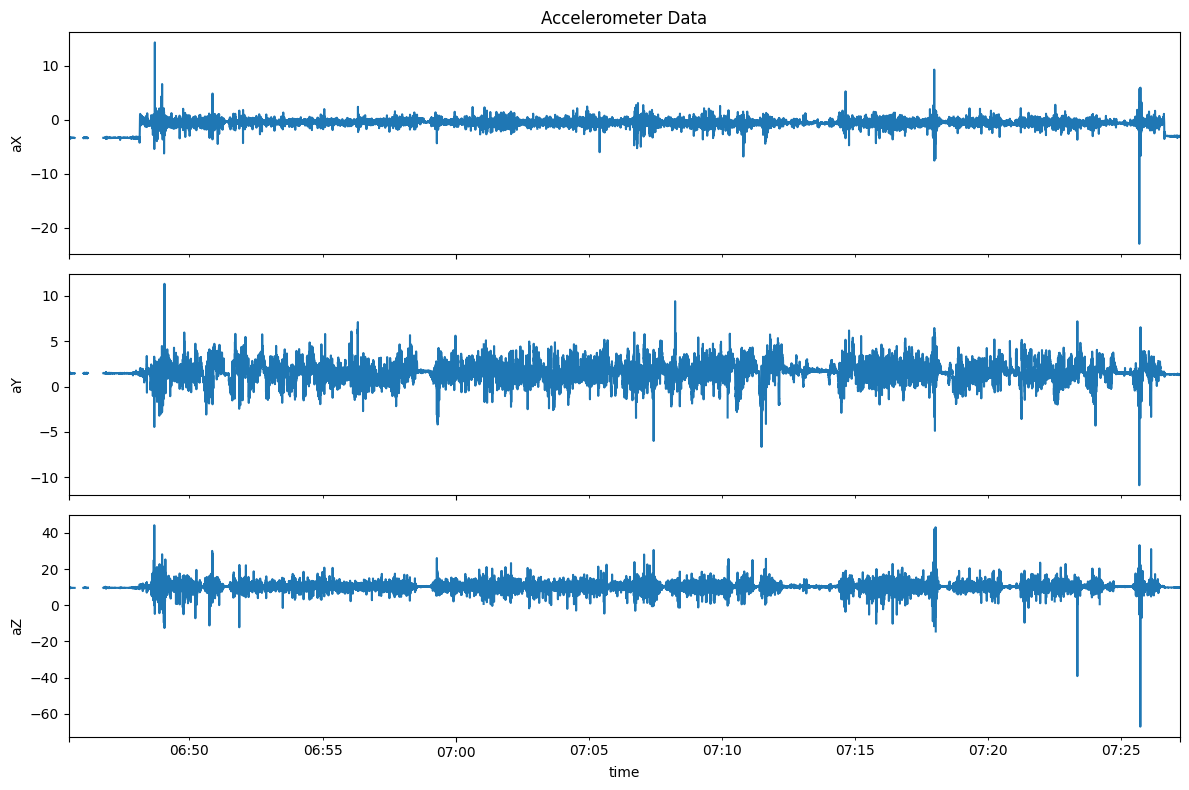

In [ ]:
# Plot for Accelerometer (ax,zy,az)

fig, axs = plt.subplots(3,1, figsize=(12,8), sharex=True)
axs[0].set_title("Accelerometer Data")

df_plot["imu_ax"].plot(ax=axs[0])
axs[0].set_ylabel("aX")

df_plot["imu_ay"].plot(ax=axs[1])
axs[1].set_ylabel("aY")

df_plot["imu_az"].plot(ax=axs[2])
axs[2].set_ylabel("aZ")
axs[2].set_xlabel("time")

plt.tight_layout()
plt.show()

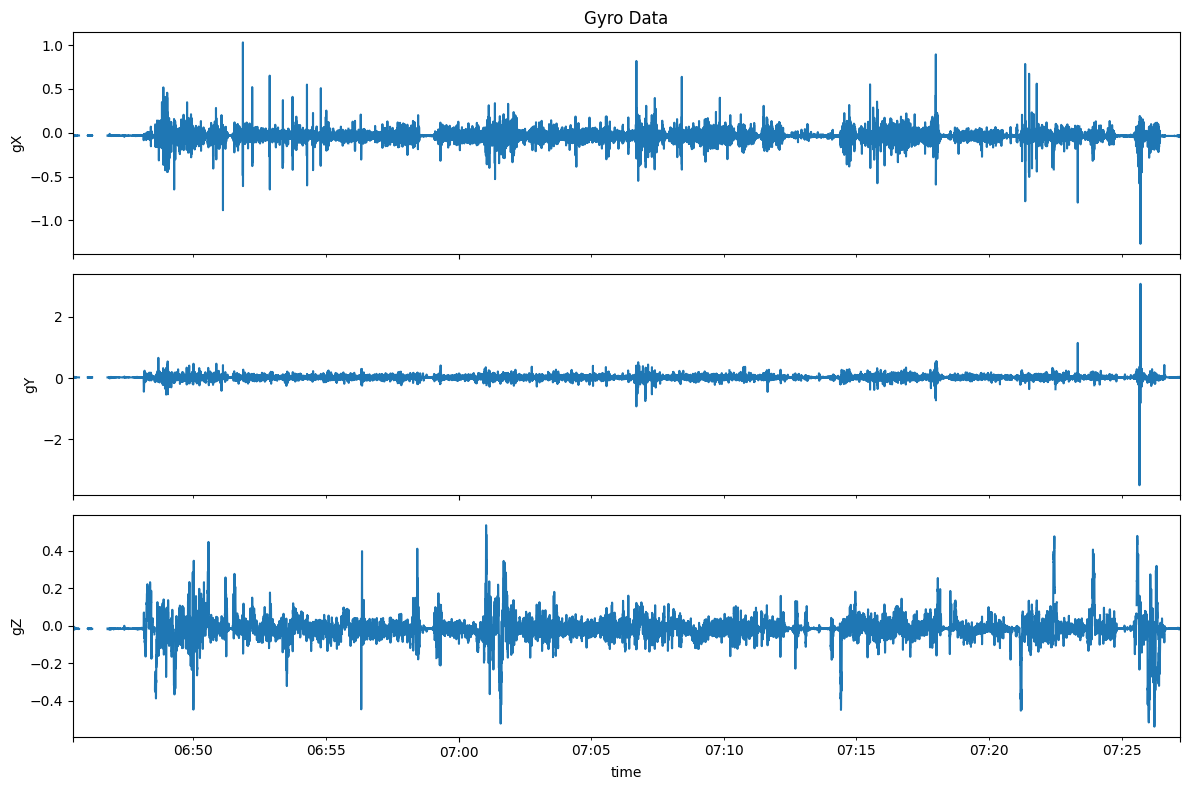

In [ ]:
# Plot for Gyroscrope (ax,zy,az)


fig, axs = plt.subplots(3,1, figsize=(12,8), sharex=True)
axs[0].set_title("Gyro Data")

df_plot["imu_gx"].plot(ax=axs[0])
axs[0].set_ylabel("gX")

df_plot["imu_gy"].plot(ax=axs[1])
axs[1].set_ylabel("gY")

df_plot["imu_gz"].plot(ax=axs[2])
axs[2].set_ylabel("gZ")
axs[2].set_xlabel("time")

plt.tight_layout()
plt.show()

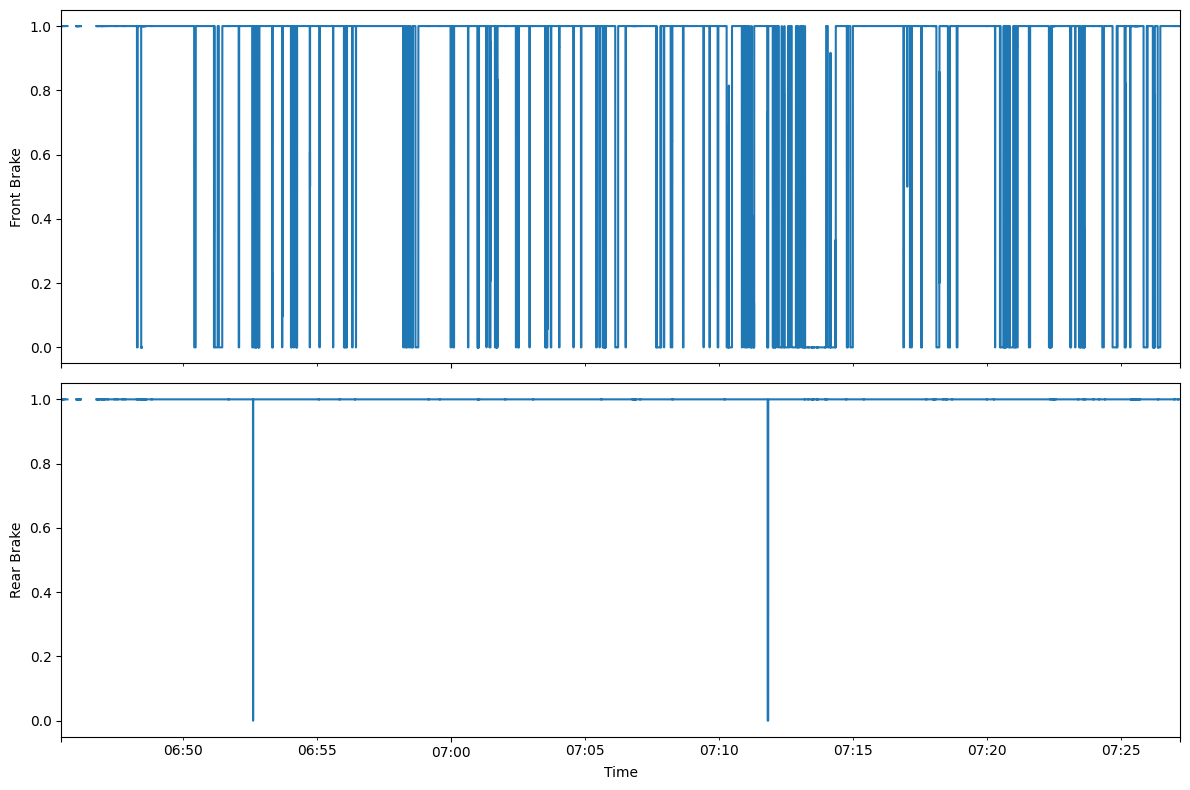

In [ ]:
# Plot Brake Engagement Signals

fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

df_plot["digital_d5"].plot(ax=axs[0], drawstyle="steps-post")
axs[0].set_ylabel("Front Brake")

df_plot["digital_d6"].plot(ax=axs[1], drawstyle="steps-post")
axs[1].set_ylabel("Rear Brake")

axs[1].set_xlabel("Time")
plt.tight_layout()
plt.show()